In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import csv
import glob
import math


# **********
# Calculate true and pixel distances between features
# **********
def correlate_features(features, depth_val):
    result = ['id', 'sym_s', 'x_s', 'y_s', 'pixel_x_s', 'pixel_y_s', 'calc_pixel_x_s', 'calc_pixel_y_s',
              'sym_t', 'x_t', 'y_t', 'pixel_x_t', 'pixel_y_t', 'calc_pixel_x_t', 'calc_pixel_y_t',
              'dis_m_x', 'dis_m_y', 'dis_m', 'dis_pix_x', 'dis_pix_y', 'dis_pix', 'dis_c_pix_x', 'dis_c_pix_y',
              'dis_c_pix', 'bear_pix', 'dis_depth_pix', 'bear_c_pix', 'dis_depth_c_pix']

    results = []
    results.append(result)
    count = 1
    i = 0
    j = 0
    features.remove(features[0])  # remove the headers
    features.sort()  # sort alphabethically
    for f1 in features:
        i = j
        while i < len(features):
            if f1[1] != features[i][1]:
                dis_m_x = int(features[i][3]) - int(f1[3])
                dis_m_y = int(features[i][4]) - int(f1[4])
                dis_m = math.sqrt(math.pow(dis_m_x,2) + math.pow(dis_m_y,2))

                if f1[5] != 0 and features[i][5] != 0:
                    dis_pix_x = int(features[i][5]) - int(f1[5])
                    dis_pix_y = int(features[i][6]) - int(f1[6])
                else:
                    dis_pix_x = 0
                    dis_pix_y = 0
                dis_pix = math.sqrt(math.pow(dis_pix_x, 2) + math.pow(dis_pix_y, 2))

                if features[i][7] != 0 and f1[7] != 0:
                    dis_c_pix_x = int(features[i][7]) - int(f1[7])
                    dis_c_pix_y = int(features[i][8]) - int(f1[8])
                else:
                    dis_c_pix_x = 0
                    dis_c_pix_y = 0
                dis_c_pix = math.sqrt(math.pow(dis_c_pix_x,2) + math.pow(dis_c_pix_y,2))

                bear_pix = calc_bearing(f1[5], f1[6], features[i][5], features[i][6])
                if bear_pix != 0 and bear_pix <= 180:
                    dis_depth_pix = (abs(bear_pix-90)/90 + depth_val) * dis_pix
                elif bear_pix != 0 and bear_pix > 180:
                    dis_depth_pix = (abs(bear_pix - 270) / 90 + depth_val) * dis_pix
                else:
                    dis_depth_pix = 0

                bear_c_pix = calc_bearing(f1[7], f1[8], features[i][7], features[i][8])
                if bear_c_pix != 0 and bear_c_pix <= 180:
                    dis_depth_c_pix = (abs(bear_c_pix - 90) / 90 + depth_val) * dis_c_pix
                elif bear_c_pix != 0 and bear_c_pix > 180:
                    dis_depth_c_pix = (abs(bear_c_pix - 270) / 90 + depth_val) * dis_c_pix
                else:
                    dis_depth_c_pix = 0

                result = [str(count), f1[1], f1[3], f1[4], f1[5], f1[6], f1[7], f1[8],features[i][1], features[i][3],
                          features[i][4], features[i][5], features[i][6], features[i][7], features[i][8],
                          dis_m_x, dis_m_y, dis_m, dis_pix_x, dis_pix_y ,dis_pix, dis_c_pix_x, dis_c_pix_y, dis_c_pix,
                          bear_pix, dis_depth_pix, bear_c_pix, dis_depth_c_pix]

                results.append(result)
                count += 1
            i += 1
        j += 1
    return results


# **********
# Calculation of the bearing from point 1 to point 2
# **********
def calc_bearing (x1, y1, x2, y2):
    if x1 == 0 or x2 == 0 or y1 == 0 or y2 == 0:
        degrees_final = 0
    else:
        deltaX = x2 - x1
        deltaY = y2 - y1

        degrees_temp = math.atan2(deltaX, deltaY) / math.pi * 180

        if degrees_temp < 0:
            degrees_final = 360 + degrees_temp
        else:
            degrees_final = degrees_temp

        if degrees_final < 180:
            degrees_final = 180 - degrees_final
        else:
            degrees_final = 360 + 180 - degrees_final

    return degrees_final


# **********
# Camera calibration process
# **********
def calibrate_camera(size):
    CHECKERBOARD = (6, 9)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, size, 0.001)  # was 30

    objpoints = []   # Creating vector to store vectors of 3D points for each checkerboard image
    imgpoints = []   # Creating vector to store vectors of 2D points for each checkerboard image

    # Defining the world coordinates for 3D points
    objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
    objp[0, :, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
    prev_img_shape = None

    images = glob.glob('.\camera_calibration\images\*.jpg')   # TODO: change the path according to the path in your environmrnt
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chess board corners
        # If desired number of corners are found in the image then ret = true
        ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD,
                                                 cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

        if ret == True:
            objpoints.append(objp)
            # refining pixel coordinates for given 2d points.
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)
            print(fname)

        cv2.waitKey(0)

    cv2.destroyAllWindows()
    h, w = img.shape[:2]
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return ret, mtx, dist, rvecs, tvecs


# **********
# Find homographies function
# **********
def find_homographies(recs, camera_locations, im, show, ransacbound, outputfile):
    #print(recs)
    pixels = []
    pos3ds = []
    symbols = []
    for r in recs: 
        pixels.append(r['pixel'])
        pos3ds.append(r['pos3d'])
        symbols.append(r['symbol'])
    pixels = np.array(pixels)
    pos3ds = np.array(pos3ds)
    symbols = np.array(symbols)
    loc3ds = []
    grids = []
    for cl in camera_locations: 
        grids.append(cl['grid_code'])
        loc3ds.append(cl['pos3d'])
    grids = np.array(grids)
    loc3ds = np.array(loc3ds)
    num_matches = np.zeros((loc3ds.shape[0],2))
    scores = []
    for i in range(0, grids.shape[0], 1):  # 50
        if grids[i] >= grid_code_min:
            if show:
                print(i,grids[i],loc3ds[i])
            num_matches[i, 0], num_matches[i, 1] = find_homography(recs, pixels, pos3ds, symbols, loc3ds[i], im, show, ransacbound, outputfile)
        else:
            num_matches[i, :] = 0
        score = [i+1, num_matches[i, 0], num_matches[i, 1], grids[i], loc3ds[i][0], loc3ds[i][1], loc3ds[i][2]]
        scores.append(score)

    if show is False:
        outputCsv = output.replace(".png","_location.csv")
        csvFile = open(outputCsv, 'w', newline='', encoding='utf-8')
        csvWriter = csv.writer(csvFile)
        csvWriter.writerow(['location_id', 'min_score', 'max_score', 'grid_code', 'Z', 'X', 'Y'])
        for s in scores:
            csvWriter.writerow(s)

    return num_matches

def from2d_to_3d(point_2d,H):
    point_3d = np.matmul(np.linalg.inv(H),point_2d)        
    point_3d = point_3d/point_3d[2]
    return point_3d

def fromRealImage2DTocalc3D(H_inv,camera_location,calc2Dpixel, real3D):
    H_inv_mult_pixel = np.dot(H_inv,calc2Dpixel) 
    v_norm = math.sqrt(pow(H_inv_mult_pixel[0],2)+pow(H_inv_mult_pixel[1],2)+pow(H_inv_mult_pixel[2],2))
    
    v_3d_direction = H_inv_mult_pixel/v_norm
    v_3d_direction = -1 * v_3d_direction
    # function to check that norm == 1
    v_3d_direction_norm = math.sqrt(pow(v_3d_direction[0],2)+pow(v_3d_direction[1],2)+pow(v_3d_direction[2],2)) 
    print('v_3d_direction_norm',v_3d_direction_norm)
    alpha = np.dot(v_3d_direction , np.subtract(real3D,camera_location))
    calc3D = np.add(np.dot(alpha,v_3d_direction),camera_location)
    d = np.subtract(calc3D , real3D)
    
    d_norm = math.sqrt(pow(d[0],2)+pow(d[1],2)+pow(d[2],2))
    print('d_norm:',d_norm)
    print('\n','\n', "real3D:",real3D,'\n',"calc3D:",calc3D,'\nalpha',alpha) 
    #print(7777,(d_norm),'\n','\n') 
    return d_norm

def gis3d_to_2d(pixels,pos3ds,manual_points_in_src,camera_location):
    gis2d_list = np.zeros((pixels.shape[0],2))
    for i in range(pixels.shape[0]):#pixels len
        #if i==1:
            #print('pos3ds[i,:]:',pos3ds[i,:],'camera_location:', camera_location )
        manual_points_in_src[i] = pixels[i,0]!=0 or pixels[i,1]!=0
        gis2d = pos3ds[i,:] - camera_location # remove camera locations
        gis2d = np.array([gis2d[0],gis2d[1],gis2d[2]])
        if gis2d[2] != 0:
            gis2d = gis2d/gis2d[2] #normal
        gis2d_list[i,:]=gis2d[0:2]
    return gis2d_list,manual_points_in_src
# **********
# Find homography function
# **********
def find_homography(recs, pixels, pos3ds, symbols, camera_location, im, show, ransacbound, outputfile):
    #manual_points_in_src = np.zeros(pixels.shape[0])#manual_points_in_src = real point or not - 1/0
    #print('recs77: ',recs)
    pos2 = np.zeros((pixels.shape[0],2))
    good = np.zeros(pixels.shape[0])
    gis2d_list,manual_points_in_src = gis3d_to_2d(pixels,pos3ds,good,camera_location)
    for i in range(pixels.shape[0]):
        good[i] = pixels[i,0]!=0 or pixels[i,1]!=0
        p = pos3ds[i,:] - camera_location
        p = np.array([p[0],p[1],p[2]])
        if p[2] != 0:
            p = p/p[2]
        pos2[i,:]=p[0:2]
    #print(pixels)
    
    if show:
        #M, mask = cv2.findHomography(pos2[good==1],pixels[good==1],cv2.LMEDS)
        M, mask = cv2.findHomography(pos2[good==1],pixels[good==1],cv2.RANSAC,1000)
        #M, mask = cv2.findHomography(pos2[good==1],pixels[good==1],cv2.RANSAC,120)
    else:
        M, mask = cv2.findHomography(pos2[good==1],pixels[good==1],cv2.RANSAC,120)
    M = np.linalg.inv(M)
    H_inv = np.linalg.inv(M)
    greens_features = []
    if show:
        print('Mmask77',np.sum(mask))
        print('M77',M)
    if show:
        plt.figure(figsize=(40, 20))
        plt.imshow(im)
        for rec in recs:
            symbol = rec['symbol']
            pixel = rec['pixel']
            if pixel[0]!= 0 or pixel[1]!=0 and symbol == 'A2':
                plt.text(pixel[0],pixel[1],symbol, color='yellow',fontsize=20, weight ='bold')
            else:
                print('black: ' , rec['name'])
            
                #plt.text(pixel[0],pixel[1],symbol, style='italic',fontsize=30, weight ='bold', bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8),))
    err1 = 0
    err2 = 0
    feature = ['id', 'symbol', 'name', 'x', 'y', 'pixel_x', 'pixel_y', 'calc_pixel_x', 'calc_pixel_y']
    features = []
    features.append(feature)
    for i in range(pos2[good == 1].shape[0]):
        pp = np.array([pos2[good == 1][i,0],pos2[good == 1][i, 1], 1.0])
        p1Real = pixels[good == 1][i, :]
        real3d = pos3ds[good == 1][i, :]
        
        p2Real = np.array([gis2d_list[good == 1][i,0],gis2d_list[good == 1][i, 1], 1.0])      
        p1Calc = from2d_to_3d(p2Real,H_inv)
        
        if show:
            
            p2Real_order = np.array([pp[0],pp[1],pp[2]])
            p2Real_order_norm = p2Real_order / p2Real_order[2]
            #p1Calc_order = from2d_to_3d(p2Real_order_norm,H_inv)PP2
            
            p1Real_order = np.array([p1Real[0],p1Real[1],1])
            p1Real_order_norm = p1Real_order / p1Real_order[2]
            p1Calc_order = from2d_to_3d(p2Real_order_norm,M)
            fromRealImage2DTocalc3D(M,camera_location,p1Real_order_norm, real3d);
            print('H',M)
            print('H inv',H_inv)
            
            print("p1Calc:",p1Calc,"p1Calc_order:",p1Calc_order,'\n',"p1Real:"\
                  ,p1Real,'\n',\
                  "real3d:",real3d,'\n',"camera_location:",camera_location,'\n')

        
        
        p1 = pixels[good == 1][i, :]
        pp = np.array([pos2[good == 1][i,0],pos2[good == 1][i, 1], 1.0])
        pp2 = np.matmul(np.linalg.inv(M),pp)
        pp2 = pp2/pp2[2]
        P1 = np.array([p1[0],p1[1],1.0])
        PP2 = np.matmul(M,P1)
        PP2 = PP2/PP2[2]
        P2 = pos2[good==1][i,:]
        if show and good[i]:
            print(i)
            print(mask[i]==1,p1,pp2[0:2],np.linalg.norm(p1-pp2[0:2]))
            print(mask[i]==1,P2,PP2[0:2],np.linalg.norm(P2-PP2[0:2]))
        if mask[i] == 1:
            err1 += np.linalg.norm(p1-pp2[0:2])
            err2 += np.linalg.norm(P2-PP2[0:2])
        if show:
            distance2dPoints = []
            distance2dPoint = np.linalg.norm(p1Real - [pp2[0], pp2[1]])
            print('distance between real 2d and calc 2d:',distance2dPoint)
            distance2dPoints.append(distance2dPoint)
            color = 'green' if mask[i] == 1 else 'red'
            plt.plot([p1[0],pp2[0]],[p1[1],pp2[1]],color = color, linewidth=3)
            plt.plot(p1[0], p1[1], marker = 'X', color=color, markersize=5)
            plt.plot(pp2[0], pp2[1], marker='o', color=color, markersize=5)
            if color == 'green':
                distance2dPoints.append(distance2dPoint)
            sym = ''
            name = ''
            for r in recs:
                px = r['pixel'].tolist()
                if px[0] == p1[0] and px[1] == p1[1]:
                    sym = r['symbol']
                    name = r['name']
                    x = r['pos3d'][0]
                    y = r['pos3d'][1]
                    break
            feature = [i, sym, name, x, y, p1[0], p1[1], pp2[0], pp2[1]]
            if(color == 'green' ):
                print('green: ' ,feature)
            else:
                print('red: ' ,feature)
                greens_features.append(feature)
            features.append(feature)
        
    i = -1
    for r in recs:    # Extracting features that were not noted on the image (pixel_x and pixel_y are 0)
        i += 1
        p1 = pixels[i,:]
        if p1[0] == 0 and p1[1] == 0:
            pp = np.array([pos2[i,0],pos2[i,1],1.0])
            pp2 = np.matmul(np.linalg.inv(M),pp)
            pp2 = pp2/pp2[2]
            if show:
                if r['symbol'] == 'A2':
                    plt.text(pp2[0],pp2[1],r['symbol'],color='black',fontsize=30, style='italic',
                             weight='bold')
                    plt.plot(pp2[0],pp2[1],marker='s', markersize=10, color='black')
                x = r['pos3d'][0]
                y = r['pos3d'][1]
                feature = [i, recs[i]['symbol'], recs[i]['name'], x, y, 0, 0, pp2[0], pp2[1]]
                features.append(feature)
    if show:
        outputCsv = output.replace(".png", "_accuracies.csv")
        csvFile = open(outputCsv, 'w', newline='', encoding='utf-8')
        csvWriter = csv.writer(csvFile)
        for f in features:
            csvWriter.writerow(f)

        # send features to the function that correlates between the feature themsrlves
        results = correlate_features(features, 1)
        # get the results and write to a nother CSV file
        outputCsv = output.replace(".png", "_correlations.csv")
        csvFile = open(outputCsv, 'w', newline='', encoding='utf-8')
        csvWriter = csv.writer(csvFile)
        for r in results:
            csvWriter.writerow(r)

        print('Output file: ',outputfile)
        plt.savefig(outputfile, dpi=300)
        plt.show()

    err2 += np.sum(1-mask)*ransacbound
    if show:
        print ('err',err1,err1/np.sum(mask),err2,err2/np.sum(mask))
        print('distance2dPoints mean:',np.average(distance2dPoints))
    return err1,err2


# **********
# read data from the features file
# **********
def read_points_data(filename,pixel_x,pixel_y,scale):
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        recs = []
        for row in csv_reader:
            if line_count == 0:
                print(f'Column names are {", ".join(row)}')
                line_count += 1
                names = row
                indx = names.index(pixel_x)
                indy = names.index(pixel_y)
            else:
                line_count += 1
                
                symbol = row[6]
                pixel = np.array([int(row[indx]),int(row[indy])])/scale
                height = float(row[5]) + float(row[2])
                pos3d = np.array([float(row[3]),float(row[4]),height])
                name = row[1]
                print(393,pixel) 
                rec = {'symbol' : symbol,
                        'pixel' : pixel,
                        'pos3d' : pos3d,
                        'name' : name}
                recs.append(rec)
        print(f'Processed {line_count} lines.')
        return recs


# **********
# read data from the potential camera locations file
# **********
def read_camera_locations():
    with open(camera_locations) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        recs = []
        for row in csv_reader:
            if line_count == 0:
                print(f'Column names are {", ".join(row)}')
                line_count += 1
                names = row
            else:
                line_count += 1
                grid_code = int(row[2])
                height = float(row[5]) + 2.0    # addition of 2 meters  as the observer height
                pos3d = np.array([float(row[3]),float(row[4]),height])
                rec = {'grid_code' : grid_code,
                       'pos3d' : pos3d}
                recs.append(rec)
        print(f'Processed {line_count} lines.')
        return recs
    

# **********
# Main function
# **********
def do_it(image_name, features, pixel_x, pixel_y, output, scale):
    im = cv2.imread(image_name)
    im2 = np.copy(im)
    im[:,:,0] = im2[:,:,2]
    im[:,:,1] = im2[:,:,1]
    im[:,:,2] = im2[:,:,0]

    plt.figure(figsize=(11.69, 8.27))  # 40,20
    plt.imshow(im)
    
    recs = read_points_data(features,pixel_x,pixel_y,scale)
    print(442,recs)
    locations = read_camera_locations()
    pixels = []
    for rec in recs:
        symbol = rec['symbol']
        pixel = rec['pixel']
        if pixel[0] != 0 or pixel[1] != 0:
            plt.text(pixel[0],pixel[1],symbol,color='red',fontsize=38)
        pixels.append(pixel)

    num_matches12 = find_homographies(recs, locations, im, False, 120.0, output)
    num_matches2 = num_matches12[:, 1]
    #print(np.min(num_matches2[num_matches2 > 0]))
    #print(np.max(num_matches2[num_matches2 > 0]))

    num_matches2[num_matches2 == 0] = 1000000
    print(np.min(num_matches2))

    theloci = np.argmin(num_matches2)      # theloci contains the best location for the camera
    print('location id: ' + str(theloci) + ' - ' + str(locations[theloci]))

    find_homographies(recs, [locations[theloci]], im, True, -1, output)  # Orig = 120.0


#img = '5'
#img = '15'
#img = '7'
#img = '13'
#img = '11'
#img = '6'
#img = '4'
#img = '1'
#img = '3'
#img = '0539'
#img = '0518'
#img = 'Henn'
#img = 'Broyn'
img = 'Tirion'
#img = '16'
#img = '17'

camera_locations = ''
grid_code_min = 7
                      
if img == '5':
    ret, mtx, dist, rvecs, tvecs = calibrate_camera(23)
    img = cv2.imread('5.jpg')
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)   # un-distort
    cv2.imwrite('tmpp5.png', dst)

    image_name = 'tmpp5.png'
    features = 'features.csv'
    camera_locations = 'potential_camera_locations_3D.csv'
    pixel_x = 'Pixel_x_5'
    pixel_y = 'Pixel_y_5'
    output = 'zOutput_5.png'
    scale = 1.0           
elif img == '15':
    ret, mtx, dist, rvecs, tvecs = calibrate_camera(23)
    img = cv2.imread('15.jpg')
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)   # un-distort
    cv2.imwrite('tmpp15.png', dst)

    image_name = 'tmpp15.png'
    features = 'features.csv'
    camera_locations = 'potential_camera_locations_3D.csv'
    pixel_x = 'Pixel_x_15'
    pixel_y = 'Pixel_y_15'
    output = 'zOutput_15.png'
    scale = 1.0 
                      
elif img == '7':
    ret, mtx, dist, rvecs, tvecs = calibrate_camera(23)
    img = cv2.imread('7.jpg')
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)   # un-distort
    cv2.imwrite('tmpp77.png', img)

    image_name = 'tmpp77.png'
    features = 'features.csv'
    camera_locations = 'potential_camera_locations_3D.csv'
    pixel_x = 'Pixel_x_7'
    pixel_y = 'Pixel_y_7'
    output = 'zOutput_77.png'
    scale = 1.0 
                      
elif img == '13':
    ret, mtx, dist, rvecs, tvecs = calibrate_camera(23)
    img = cv2.imread('13.jpg')
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)   # un-distort
    cv2.imwrite('tmpp13.png', dst)

    image_name = 'tmpp13.png'
    features = 'features.csv'
    camera_locations = 'potential_camera_locations_3D.csv'
    pixel_x = 'Pixel_x_13'
    pixel_y = 'Pixel_y_13'
    output = 'zOutput_13.png'
    scale = 1.0 
                      
elif img == '11':
    ret, mtx, dist, rvecs, tvecs = calibrate_camera(23)
    img = cv2.imread('11.jpg')
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)   # un-distort
    cv2.imwrite('tmpp11.png', dst)

    image_name = 'tmpp11.png'
    features = 'features.csv'
    camera_locations = 'potential_camera_locations_3D.csv'
    pixel_x = 'Pixel_x_11'
    pixel_y = 'Pixel_y_11'
    output = 'zOutput_11.png'
    scale = 1.0 

elif img == '6':
    ret, mtx, dist, rvecs, tvecs = calibrate_camera(23)
    img = cv2.imread('6.jpg')
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)   # un-distort
    cv2.imwrite('tmpp6.png', dst)

    image_name = 'tmpp6.png'
    features = 'features.csv'
    camera_locations = 'potential_camera_locations_3D.csv'
    pixel_x = 'Pixel_x_6'
    pixel_y = 'Pixel_y_6'
    output = 'zOutput_6.png'
    scale = 1.0
                      
elif img == '4':
    ret, mtx, dist, rvecs, tvecs = calibrate_camera(23)
    img = cv2.imread('4.jpg')
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)   # un-distort
    #cv2.imwrite('tmpp4.png', dst)

    image_name = '4.jpg'
    features = 'features.csv'
    camera_locations = 'potential_camera_locations_3D.csv'
    pixel_x = 'Pixel_x_4'
    pixel_y = 'Pixel_y_4'
    output = 'zOutput_4.png'
    scale = 1.0 
                      
elif img == '1':
    #ret, mtx, dist, rvecs, tvecs = calibrate_camera(23)
    img = cv2.imread('1.jpg')
    h, w = img.shape[:2]
    #newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
    #dst = cv2.undistort(img, mtx, dist, None, newcameramtx)   # un-distort
    #cv2.imwrite('tmpp11.png', dst)

    image_name = '1.jpg'
    features = 'features.csv'
    camera_locations = 'potential_camera_locations_3D.csv'
    pixel_x = 'Pixel_x_1'
    pixel_y = 'Pixel_y_1'
    output = 'zOutput_1.png'
    scale = 1.0 
                      
elif img == '3':
    ret, mtx, dist, rvecs, tvecs = calibrate_camera(23)
    img = cv2.imread('3.jpg')
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)   # un-distort
    cv2.imwrite('tmpp3.png', dst)

    image_name = 'tmpp3.png'
    features = 'features.csv'
    camera_locations = 'potential_camera_locations_3D.csv'
    pixel_x = 'Pixel_x_3'
    pixel_y = 'Pixel_y_3'
    output = 'zOutput_3.png'
    scale = 1.0 
                                            
elif img == '16':
    image_name = '16.jpg'
    features = 'features.csv'
    camera_locations = 'potential_camera_locations_3D.csv'
    pixel_x = 'Pixel_x_16'
    pixel_y = 'Pixel_y_16'
    output = 'zOutput_16.png'
    scale = 1.0 
                      
elif img == '17':
    image_name = '17.JPG'
    features = 'features.csv'
    camera_locations = 'potential_camera_locations_3D.csv'
    pixel_x = 'Pixel_x_17'
    pixel_y = 'Pixel_y_17'
    output = 'zOutput_17.png'
    scale = 1.0
                      
elif img == '0539':
    ret, mtx, dist, rvecs, tvecs = calibrate_camera(23)
    img = cv2.imread('DSC_0539.tif')
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)   # un-distort
    cv2.imwrite('tmpDSC_0539.png', dst)

    image_name = 'tmpDSC_0539.png'
    features = 'features.csv'
    camera_locations = 'potential_camera_locations_3D.csv'
    pixel_x = 'Pixel_x_DSC_0539'
    pixel_y = 'Pixel_y_DSC_0539'
    output = 'zOutput_DSC_0539.png'
    scale = 1.0
    
elif img == '0518':
    ret, mtx, dist, rvecs, tvecs = calibrate_camera(23)
    img = cv2.imread('DSC_0518.tif')
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)   # un-distort
    cv2.imwrite('tmpDSC_0518.png', dst)

    image_name = 'tmpDSC_0518.png'
    features = 'features.csv'
    camera_locations = 'potential_camera_locations_3D.csv'
    pixel_x = 'Pixel_x_DSC_0518'
    pixel_y = 'Pixel_y_DSC_0518'
    output = 'zOutput_DSC_0518.png'
    scale = 1.0
elif img == 'Henn':
    image_name = 'NNL_Henniker.jpg'
    features = 'features.csv'
    camera_locations = 'potential_camera_locations_3D.csv'
    pixel_x = 'Pixel_x_Henniker'
    pixel_y = 'Pixel_y_Henniker'
    output = 'zOutput_Henniker.png'
    scale = 1.0

elif img == 'Broyn':
    image_name = 'de-broyn-1698.tif'
    features = 'features.csv'
    camera_locations = 'potential_camera_locations_3D.csv'
    pixel_x = 'Pixel_x_Broyin'
    pixel_y = 'Pixel_y_Broyin'
    output = 'zOutput_Broyin.png'
    scale = 1.0
elif img == 'Tirion':
    image_name = 'Tirion-1732.tif'
    features = 'features.csv'
    camera_locations = 'potential_camera_locations_3D.csv'
    pixel_x = 'Pixel_x_Tirion'
    pixel_y = 'Pixel_y_Tirion'
    output = 'zOutput_Tirion.png'
    scale = 1.0
elif img == 'Laboard_b':
    image_name = 'laboard_before.tif'
    features = 'features_tiberias.csv'
    camera_locations = 'potential_camera_locations_tiberias_3D.csv'
    pixel_x = 'Pixel_x_Laboard_b'
    pixel_y = 'Pixel_y_Laboard_b'
    output = 'zOutput_Laboard_b.png'
    scale = 1.0
else:
    print('No file was selected')

do_it(image_name,features,pixel_x,pixel_y,output,scale)


print ('**********************')
# print ('ret: ')
# print (ret)
# print ('mtx: ')
# print (mtx)
# print ('dist: ')
# print (dist)
# print('rvecs: ')
# print(rvecs)
# print ('tvecs: ')
# print(tvecs)

print ('Done!')







Column names are OBJECTID, Name, Height, POINT_X, POINT_Y, POINT_Z, Symbol, Pixel_x_17, Pixel_y_17, Pixel_x_3, Pixel_y_3, Pixel_x_Henniker, Pixel_y_Henniker, Pixel_x_DSC_0539, Pixel_y_DSC_0539, Pixel_x_DSC_0518, Pixel_y_DSC_0518, Pixel_x_Broyin, Pixel_y_Broyin, Pixel_x_Tirion, Pixel_y_Tirion, Pixel_x_16, Pixel_y_16, Pixel_x_1, Pixel_y_1, Pixel_x_4, Pixel_y_4, Pixel_x_6, Pixel_y_6, Pixel_x_5, Pixel_y_5, Pixel_x_15, Pixel_y_15, Pixel_x_7, Pixel_y_7, Pixel_x_13, Pixel_y_13, Pixel_x_11, Pixel_y_11
393 [0. 0.]
393 [106. 386.]
393 [0. 0.]
393 [150. 410.]
393 [156. 416.]
393 [188. 387.]
393 [0. 0.]
393 [197. 351.]
393 [0. 0.]
393 [243. 402.]
393 [485. 385.]
393 [242. 369.]
393 [0. 0.]
393 [100. 409.]
393 [334. 389.]
393 [318. 374.]
393 [543. 434.]
393 [281. 431.]
393 [403. 388.]
393 [467. 419.]
393 [339. 374.]
393 [365. 374.]
393 [587. 411.]
393 [737. 430.]
393 [0. 0.]
393 [497. 409.]
393 [0. 0.]
393 [0. 0.]
393 [0. 0.]
393 [613. 436.]
393 [677. 434.]
393 [704. 432.]
393 [542. 387.]
393 [576.

p1Calc: [-5.52401193 -2.05147298  1.        ] p1Calc_order: [478.63414318 404.42954454   1.        ] 
 p1Real: [497. 409.] 
 real3d: [222194.081  631960.2298    785.    ] 
 camera_location: [223374.25292969 631095.25756836    733.        ] 

19
[ True] [497. 409.] [478.63414318 404.42954454] 18.92600750217867
[ True] [-22.69561403  16.63408138] [-23.94467094  18.76016427] 2.4658409566640214
distance between real 2d and calc 2d: 18.92600750217867
green:  [19, 'P', 'Lady of Zion Congregation', 222194.081, 631960.2298, 497.0, 409.0, 478.63414317598654, 404.42954454213134]
v_3d_direction_norm 1.0
d_norm: 23.391203668538875

 
 real3D: [222537.5035 632019.6765    768.    ] 
 calc3D: [222552.04168388 632032.73092518    755.14031098] 
alpha 1247.1478744915523
H [[-5.89253561e-04 -2.46831760e-03  2.57277103e+00]
 [-2.06503407e-03 -2.21043230e-03  9.35079518e-01]
 [-6.94464825e-05  1.13100581e-03 -4.81120873e-01]]
H inv [[-1.55606997e+00 -4.53864695e+02 -8.90426951e+02]
 [ 2.78936827e+02 -1.217

KeyboardInterrupt: 

In [46]:
import os
import arcpy
import pyproj
import numpy as np

#img = '1'
#img = '5'
#img = '6'
#img = '7'
#img = '13'
#img = '15'
#img = '16'
#img = '17'
#img = '0539'
#img = '0518'
#img = 'Henn'
img = 'Broyn'
#img = 'Tirion'


# CALC Area


if img == '1':
    pixel_add_name = '1'
    img_name = '1.jpg'
    pred_img_name = '1_pred.jpg'
    M =  np.array([[ 7.15498794e-07, -4.64869286e-07, -6.48150799e-02],\
     [ 1.08837039e-05,  8.70721920e-07, -5.35814500e-02],\
     [ 3.38892198e-07, -8.41645601e-06,  7.10846985e-03]])
    camera_location  = [222865.06494141 ,631681.68554688  ,  744.     ]

    H = np.array([[-7.82712550e+04,  9.65803372e+04 , 1.43148754e+04],\
         [-1.68103500e+04 , 4.76047970e+03, -1.17393868e+05],\
         [-1.61719831e+01 , 1.03201468e+00 , 1.00000000e+00]])
    y_segment_move = 0

elif img == '5':
    pixel_add_name = '5'
    img_name = '5.jpg'
    pred_img_name = '5_pred_fix.jpg'
    H =  np.array([[-4.25818087e+03 , 7.20579658e+03 ,-2.04124112e+03],\
     [-1.21156665e+02 , 2.93139642e+02, -3.58402358e+03],\
     [-7.77778380e-01 , 1.11701509e-01 , 1.00000000e+00]])
    camera_location  = [223237.64147949, 631881.32067871 ,   826.        ]

    M = np.array( [[ 3.94718298e-05, -4.23120684e-04, -1.43590299e+00],\
     [ 1.65560539e-04, -3.32734639e-04, -8.54579811e-01],\
     [ 1.22069738e-05, -2.91927159e-04, -2.13564451e-02]]
    )
    y_segment_move = 0
    
if img == '6':
    pixel_add_name = '6'
    img_name = '6.jpg'
    pred_img_name = '6_pred2.jpg'
    M =  np.array([[-1.20929046e-06 ,-6.54714498e-07, -5.56540780e-03],\
     [ 1.92526983e-06 , 1.00228650e-06, -1.01312992e-02],\
     [ 1.10425431e-07 ,-2.05034240e-06  ,1.80732602e-04]]
    )
    camera_location  = [223163.1262207 , 631943.70654297,    798.        ]

    H = np.array( [[-4.25034958e+05  ,2.37980099e+05  ,2.52055847e+05],\
     [-3.02748382e+04,  8.17404278e+03, -4.74060280e+05],\
     [-8.37652731e+01 ,-5.26715629e+01 , 1.00000000e+00]],\
    )
    y_segment_move = 0
    

elif img == '7':   
    pixel_add_name = '7'
    img_name = '7.jpg'
    pred_img_name = '7_pred.jpg'
    M =  np.array([[-4.44240296e-05, -1.04746034e-04, -7.13035183e-01],\
     [ 7.21854641e-05, -7.53794690e-05, -8.52081852e-01],\
     [ 5.90177628e-07, -1.21308702e-04,  4.86781294e-03]]
    )
    camera_location  = [223250.06066895, 632205.72753906,    831.        ] 

    H = np.array([[-9.50813662e+03,  7.97514621e+03,  3.25431984e+03],\
     [-7.83025276e+01,  1.87509882e+01, -8.18747164e+03],\
     [-7.98569820e-01, -4.99627833e-01,  1.00000000e+00]]
    )
    y_segment_move = 0
    
elif img == '13':
    pixel_add_name = '13'
    img_name = '13.jpg'
    pred_img_name = '13_pred_fix.jpg'
    M =  np.array([[ 5.46861899e-04, -6.16629502e-03, -5.55191089e+00],\
     [ 8.17388723e-04 , 4.96682571e-03, -6.50108162e-01],\
     [ 2.43038016e-05, -9.28859115e-04 , 4.00160189e-01]]
    )
    camera_location  = [223336.99523926, 631095.25756836,    731.        ] 

    H = np.array([[ 1.78389726e+02,  9.82984573e+02 , 4.07199467e+03],\
     [-4.42067582e+01 , 4.56092563e+01, -5.39236631e+02],\
     [-1.13448064e-01,  4.61672899e-02 , 1.00000000e+00]]
    )
    y_segment_move = 0
    
elif img == '15':    
    pixel_add_name = '15'
    img_name = '15.jpg'
    pred_img_name = '15_pred.jpg'
    M =  np.array([[-5.51377242e-05 ,-9.08371411e-04 , 3.11593472e+00],\
     [-4.57974762e-04, -8.42501632e-05 , 4.28606726e-01],\
     [ 4.81189606e-07 , 3.54018054e-04, -2.07891754e-01]] )
    camera_location  = [222989.25708008 ,631569.39086914 ,   768.        ]  

    H = np.array([[ 3.26277972e+02 ,-2.22248466e+03 , 3.08280567e+02],\
     [ 2.30945138e+02 ,-2.42201038e+01,  3.41153057e+03],\
     [ 3.94030779e-01 ,-4.63885187e-02 , 1.00000000e+00]])
    y_segment_move = 0

elif img == '16':   
    pixel_add_name = '16'
    img_name = '16.jpg'
    pred_img_name = '16_pred.jpg'
    M =  np.array([[-1.13640481e-03, -6.16246577e-03, -3.22065044e+00],
     [ 1.70825388e-03, -2.94207061e-03, -4.08683562e+00],
     [ 2.75099149e-05, -1.17627612e-03,  1.08416584e-01]])
    camera_location  = [223374.25292969 ,631981.13818359  ,  830.        ] 

    H = np.array( [[-3.69578520e+02,  3.21293913e+02 , 1.13259597e+03],
     [-2.14579758e+01, -2.49489631e+00, -7.31482838e+02],
     [-1.39032521e-01 ,-1.08594597e-01  ,1.00000000e+00]] )
    y_segment_move = 0


elif img == '17':    
    pixel_add_name = '17'
    img_name = '17.jpg'
    pred_img_name = '17_pred.jpg'
    M =  np.array([[-5.58428771e-06 ,-1.02955632e-03 ,-2.38875451e+00],
     [ 3.32940290e-04, -1.01660362e-03, -1.48402231e+00],
     [ 1.61749493e-05 ,-4.44294911e-04 , 1.71858136e-02]])
    camera_location  = [223324.57592773 ,631981.13818359  ,  824.        ]  

    H = np.array([[-1.94231482e+03 , 3.09651636e+03 ,-2.58433582e+03],
     [-8.53068481e+01 , 1.10607408e+02 ,-2.30616120e+03],
     [-3.77320210e-01 ,-5.49107886e-02 , 1.00000000e+00]] )
    y_segment_move = 0


elif img == '0539':
    pixel_add_name = 'DSC_0539'
    img_name = 'DSC_0539.jpg'
    pred_img_name = 'DSC_0539_pred.jpg'
    M =  np.array([[-2.05304827e-04, -1.59569478e-03,  5.49866264e+00],\
     [-9.75827424e-04,  6.69029954e-04 , 5.24208012e-01],\
     [-2.34321436e-05 , 7.32681239e-04, -1.21113929e+00]])
    camera_location  =[222914.74169922, 631581.86804199 ,   754.        ] 

    H = np.array([[ 7.04857765e+02, -1.23705268e+03,  2.66468288e+03],\
     [ 7.04728174e+02, -2.22781434e+02,  3.10309368e+03],\
     [ 4.12689761e-01, -1.10838598e-01,  1.00000000e+00]])
    y_segment_move = 30


elif img == '0518':
    pixel_add_name = 'DSC_0518'
    img_name = 'DSC_0518.jpg'
    pred_img_name = 'DSC_0518_pred.jpg'
    H =  np.array([[ 9.87192865e-08 , 9.76622075e-11 ,-1.03498278e-03],
     [ 3.32745926e-07,  1.06050336e-09, -5.84907922e-04],
     [ 3.99142036e-09 ,-2.51736974e-07,  4.46469418e-04]])
    camera_location  = [222914.74169922, 631581.86804199  ,  754.        ] 

    M = np.array([[-2.03294671e+06,  3.60825913e+06 , 1.44119825e+04],
     [-2.09009749e+06 , 6.67718049e+05 ,-3.97039811e+06],
     [-1.16030449e+03 , 3.44227927e+02 , 1.00000000e+00]])
    y_segment_move = 0


elif img == 'Henn':
    pixel_add_name = 'Henniker'
    img_name = 'NNL_Henniker.jpg'
    pred_img_name = 'Hen_pred.jpg'
    M =  np.array([[-4.74584864e-04 ,-6.94555777e-03,  7.35875242e+00],\
     [-2.96901000e-03 ,-2.67471987e-03 , 1.74795249e+00],\
     [-7.20293404e-05,  1.32927328e-03, -4.71823085e-01]]
    )
    camera_location  = [223386.67211914, 631107.73474121,    737.        ] 

    H = np.array([[ 5.48526910e+01, -3.36125571e+02, -3.89731152e+02],\
     [ 7.88935234e+01 ,-3.89605350e+01 , 1.08612054e+03],\
     [ 2.13893836e-01 ,-5.84504995e-02 , 1.00000000e+00]]
    )
    y_segment_move = 0



elif img == 'Broyn':
    pixel_add_name = 'Broyin'
    img_name = 'de-broyn-1698.tif'
    pred_img_name = 'de_broyn_pred.jpg'
    M =  np.array([[-3.27576753e-04, -3.19880551e-03 , 2.36687370e+00],
     [-1.79249870e-03, -2.64373329e-03 , 5.47862297e-01],
     [-1.23896006e-04 , 1.25140985e-03 ,-1.59203311e-01]])
    camera_location  = [223361.83361816, 631095.25756836  ,  733.        ]

    H = np.array([[ 5.43793083e+01 ,-5.03852656e+02 ,-9.25438781e+02],
     [ 7.25682165e+01, -7.09551409e+01 , 8.34694677e+02],
     [ 5.28099580e-01 ,-1.65628657e-01 , 1.00000000e+00]] )
    y_segment_move = 0


elif img == 'Tirion':
    pixel_add_name = 'Tirion'
    img_name = 'Tirion-1732.tif'
    pred_img_name = 'Tirion_1732_pred.jpg'
    M =  np.array( [[-5.89253561e-04 ,-2.46831760e-03,  2.57277103e+00],
     [-2.06503407e-03, -2.21043230e-03,  9.35079518e-01],
     [-6.94464825e-05,  1.13100581e-03, -4.81120873e-01]])
    camera_location  = [223374.25292969, 631095.25756836,    733.        ]  

    H = np.array([[-1.55606997e+00, -4.53864695e+02 ,-8.90426951e+02],\
     [ 2.78936827e+02, -1.21795553e+02,  1.25488644e+03],\
     [ 6.55941684e-01, -2.20801420e-01,  1.00000000e+00]] )
    y_segment_move = 0

Processed 41 lines.

camera_location:  [223361.83361816, 631095.25756836, 733.0]
calc_pts :  [['A1', [221847.71911375786, 631136.8291268735, 791.9893943936999]], ['B', [222185.3548196133, 631286.3644657498, 751.8787656484014]], ['B1', [222274.9739654829, 631355.0701804097, 737.0514258162015]], ['C', [221987.25980743958, 631380.0314033803, 786.9078297074195]], ['D', [221667.79296853542, 631429.5317204916, 792.8902396242837]], ['E', [222414.1773501027, 631467.8218904624, 751.9738123215091]], ['E2', [222234.17795800653, 631920.8569090045, 770.979308367434]], ['F', [221665.72408393587, 631525.2282509072, 796.0564389068652]], ['G', [222100.4074429595, 631201.1652689582, 753.0202204999347]], ['H', [222314.94324674967, 631620.0900603324, 763.9951133538764]], ['I', [221835.36563950925, 631681.0066755719, 786.0194491312495]], ['J', [222558.93345597308, 631808.845347619, 749.9303731464352]], ['K', [222590.9496520902, 631483.9902443463, 729.0752361372138]], ['L', [222382.0805977612, 631701.846237

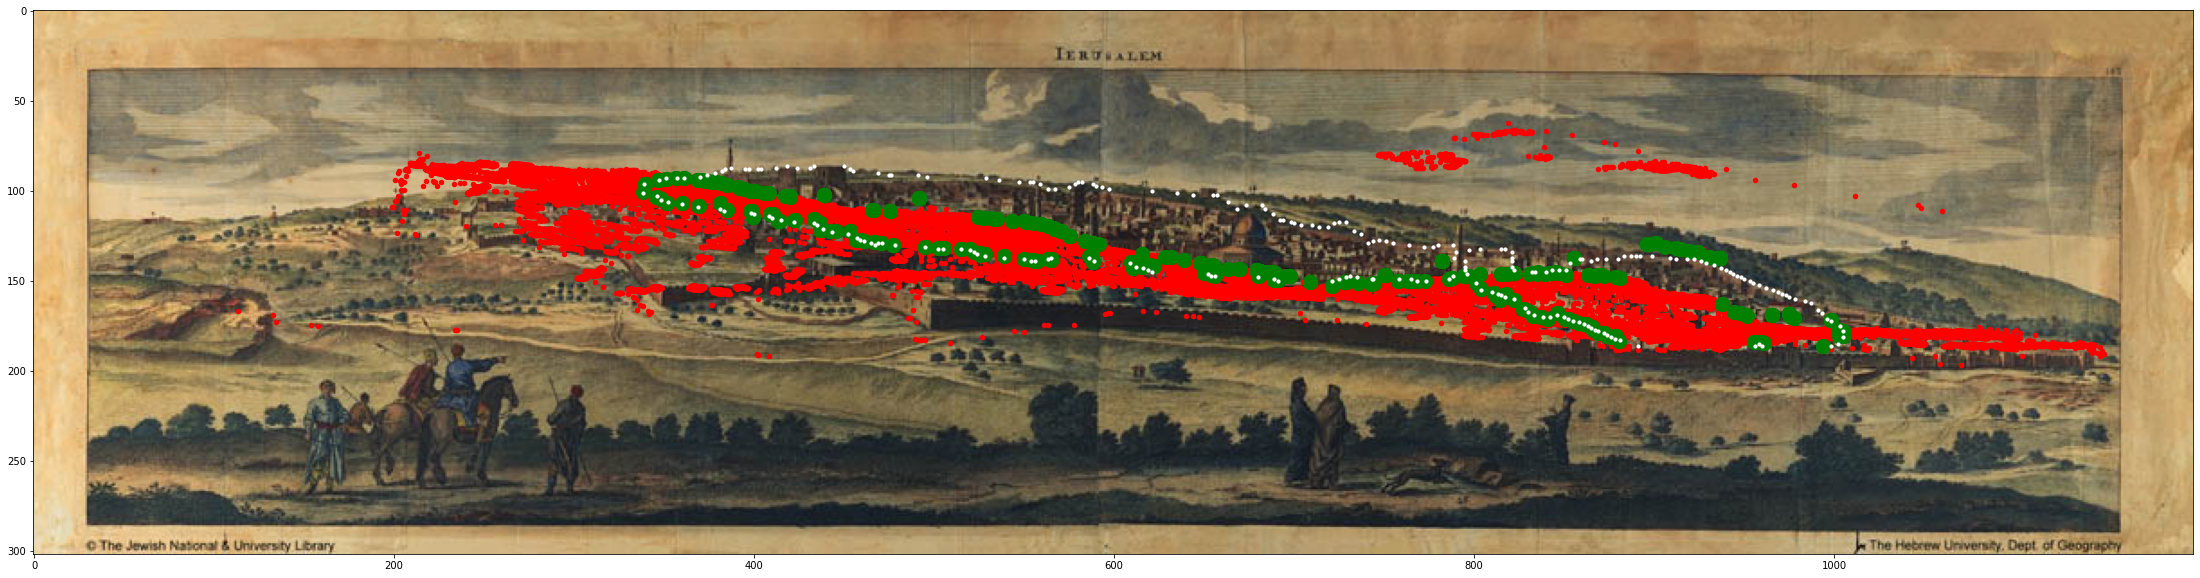

KeyboardInterrupt: 

In [53]:
# connect to gis DB and read features

# Now change the directory
#os.chdir('C:\\Program Files\\ArcGIS\\Pro\\bin\\Python\\envs\\arcgispro-py3\\')

arcpy.env.workspace = r"C:\\Users\\liat\\Documents\\buildings\\Default.gdb"
wgs84 = pyproj.CRS("EPSG:4326")
itm = pyproj.CRS("EPSG:2039")

import arcpy

input = r"C:\Users\liat\Documents\buildings\points_random100Kpoints.shp"
#input = r"C:\Users\liat\Documents\buildings\motti_12_6_22\points_random200K7777.shp"

fieldx = "SHAPE@"
fieldy = "HI_PNT_Y"
fieldz = "HI_PNT_Z"
#field_height = "HEIGHT"


import arcpy
array = arcpy.da.FeatureClassToNumPyArray(input, ("SHAPE@XYZ"), skip_nulls=True)
#print(array["SHAPE@XYZ"])



import csv
# **********
# read data from the features file
# **********
def read_points_data(filename,pixel_x,pixel_y,scale):
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        recs = []
        arrs = []
        for row in csv_reader:
            if line_count == 0:
                #print(f'Column names are {", ".join(row)}')
                line_count += 1
                names = row
                indx = names.index(pixel_x)
                indy = names.index(pixel_y)
            else:
                line_count += 1
                symbol = row[6]
                pixel = np.array([int(row[indx]),int(row[indy])])/scale
                #print('pixel',pixel[0],pixel[1])
                if pixel[0] > 0 and pixel[1]>0:
                    height = float(row[5]) + float(row[2])
                    pos3d = np.array([float(row[3]),float(row[4]),height])
                    name = row[1]

                    arr = [pos3d[0],pos3d[1],float(row[5]) ,symbol,name]
                    rec = {'symbol' : symbol,
                            'pixel' : pixel,
                            'pos3d' : pos3d,
                            'height':height,
                            'name' : name}
                    recs.append(rec)
                    arrs.append(arr)
        print(f'Processed {line_count} lines.')
        return recs,arrs



features,arr_features_0539 = read_points_data('features.csv','Pixel_x_'+pixel_add_name,'Pixel_y_'+pixel_add_name,1.0)
'''for feature in features:
    if feature['pixel'][0] >0 and  feature['pixel'][1] >0:
        print(feature['pixel'])
        print(feature['pos3d'][1])'''

                      
import PIL
import PIL.Image
import cv2
# check data is valid
fc = 'C:\\Users\\liat\\Documents\\buildings\\Default.gdb\\old_city'
fields = ['POINT_X', 'POINT_Y', 'POINT_Z']
gis2d_list = []
res_list =[]




calc_3d_to_2d_with_H = []

gis2d_np_part = array["SHAPE@XYZ"]
print('\ncamera_location: ',camera_location)

image = PIL.Image.open(img_name)
img = np.array(image)

    
#gis2d = gis2d_np_part - camera_location # remove camera locations
#print(gis2d)
for i in range(gis2d_np_part.shape[0]):

    gis2d = gis2d_np_part[i] - camera_location
    gis2d_H = np.matmul(H,gis2d)
    gis2d_H = gis2d_H/gis2d_H[2]
    calc_3d_to_2d_with_H.append(gis2d_H[0:2])

X = []
y = []
for seq, target in calc_3d_to_2d_with_H:
    X.append(seq)
    y.append(target)
    
features_pnt_list_3d = []
symbol_noted = []
features_pnt_list = np.array(arr_features_0539)    
#print(features_pnt_list[0][0])
for i in range(features_pnt_list.shape[0]):
    
    pnt_xyz = [float(features_pnt_list[i][0]),float(features_pnt_list[i][1]),float(features_pnt_list[i][2])]
    #print(pnt_xyz)
    gis2d = np.array(pnt_xyz) - np.array(camera_location)
    gis2d_H = np.matmul(H,gis2d)
    gis2d_H = gis2d_H/gis2d_H[2]
    features_pnt_list_3d.append(gis2d_H[0:2])
    symbol_noted.append(features_pnt_list[i][3])

X_noted = []
y_noted = []
for seq, target in features_pnt_list_3d:
    X_noted.append(seq)
    y_noted.append(target)
m = np.array(symbol_noted)    


# make segments greed points
img = cv2.imread(pred_img_name)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
corners = cv2.goodFeaturesToTrack(gray, 11115, 0.01, 0.5)
#corners = cv2.goodFeaturesToTrack(gray, 999995, 0.01, 0.0000000000001)
X_segments = []
y_segments = []



for corner in corners:
    x_segment, y_segment = corner[0]
    x_segment = int(x_segment)
    y_segment = int(y_segment)+y_segment_move#add variable
    X_segments.append(x_segment)
    y_segments.append(y_segment)
    #print('x: ',x_segment,'y: ', y_segment )
    
X_min_segment = min(X_segments)
X_max_segment = max(X_segments)
y_min_segment = min(y_segments)
y_max_segment = max(y_segments) 
    
    
'''from matplotlib import image
from matplotlib import pyplot as plt
  
# to read the image stored in the working directory
data = image.imread(img_name)

# to draw a point on co-ordinate (200,300)

fig, ax = plt.subplots()
fig.set_figwidth(40)
fig.set_figheight(10)
ax.scatter(X, y, s=20, marker='o', c='red')
ax.scatter(X_noted, y_noted,s=10)

for i, txt in enumerate(X_noted):
    ax.annotate(m[i], (X_noted[i], y_noted[i]), c='white')
plt.scatter(X_noted, y_noted, s=100, marker='o', c='blue')
plt.scatter(X_segments, y_segments, s=10, marker='o', c='white')
plt.imshow(data)
plt.show()'''

                      
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import csv
import glob
import math


def fromRealImage2DTocalc3D(H_inv,camera_location,calc2Dpixel, real3D):
    #print('77H_inv',H_inv)
    #H_inv = H_inv * -1
    real3D = [real3D[0],real3D[1],real3D[2]]
    H_inv_mult_pixel = np.dot(H_inv,calc2Dpixel) 
    v_norm = math.sqrt(pow(H_inv_mult_pixel[0],2)+pow(H_inv_mult_pixel[1],2)+pow(H_inv_mult_pixel[2],2))
    
    v_3d_direction = H_inv_mult_pixel/v_norm

    # in 0518 alpha_minus = False
    alpha_minus = False
    if alpha_minus == False:
        v_3d_direction = -1 * v_3d_direction
    #print('v_3d_direction',v_3d_direction)
    # function to check that norm == 1
    v_3d_direction_norm = math.sqrt(pow(v_3d_direction[0],2)+pow(v_3d_direction[1],2)+pow(v_3d_direction[2],2)) 
    #print('v_3d_direction_norm',v_3d_direction_norm)
    alpha = np.dot(v_3d_direction , np.subtract(real3D,camera_location))
    calc3D = np.add(np.dot(alpha,v_3d_direction),camera_location)
    d = np.subtract(calc3D , real3D)
    
    d_norm = math.sqrt(pow(d[0],2)+pow(d[1],2)+pow(d[2],2))
    #print('d:',d_norm)
    #print('\n','\n', "real3D:",real3D,'\n',"calc3D:",calc3D,'\nalpha',alpha) 
    distanceReal3DCalc3D = np.linalg.norm(real3D - calc3D )
    #print('distance real3D - calc3D :',distanceReal3DCalc3D) 
    #print(7777,(d_norm),'\n','\n') 
    return d_norm,alpha,calc3D

def gis3d_to_2d(pixels,pos3ds,manual_points_in_src,camera_location):
    gis2d_list = np.zeros((pixels.shape[0],2))
    for i in range(pixels.shape[0]):#pixels len
        #if i==1:
            #print('pos3ds[i,:]:',pos3ds[i,:],'camera_location:', camera_location )
        manual_points_in_src[i] = pixels[i,0]!=0 or pixels[i,1]!=0
        gis2d = pos3ds[i,:] - camera_location # remove camera locations
        gis2d = np.array([gis2d[0],gis2d[1],gis2d[2]])
        if gis2d[2] != 0:
            gis2d = gis2d/gis2d[2] #normal
        gis2d_list[i,:]=gis2d[0:2]
    return gis2d_list,manual_points_in_src


# good values when know 3d feature
from scipy import spatial
from scipy.spatial import distance

calc_pts = []
dists = []
ds = []
dss = []
d_norms = []
alphas = []
for i in range(len(features)):    
    if features[i]['pixel'][0] >0 and  features[i]['pixel'][1] >0:
        distances,indexes = spatial.KDTree(calc_3d_to_2d_with_H).query([X_noted[i], y_noted[i]], k=3)         
        
        ds = []

        datas = []
        alphas = []
        
        d_norms = []
        pts = []
        for index in indexes:
            
            data = {}

            p1Real_order = np.array([calc_3d_to_2d_with_H[index][0],calc_3d_to_2d_with_H[index][1],1])
            p1Real_order_norm = p1Real_order / p1Real_order[2]
            #print('---------------------------------------------------------------')
            d_norm,alpha,calc3D = fromRealImage2DTocalc3D(M ,camera_location,p1Real_order_norm ,\
                                                                       arr_features_0539[i])
            #print('alpha:',alpha)
            alphas.append(alpha);
            # distance 3d point in index - real feature 3d point
            distance3dPoints = np.linalg.norm(calc3D - 
                 [arr_features_0539[i][0],arr_features_0539[i][1],arr_features_0539[i][2]])
            #print('distance3dPoints:',distance3dPoints)
            d_norms.append(d_norm)
            pts.append(calc3D)
            #print(d_norm,alpha,calc3D)
            #print('---------------------------------------------------------------')
        alphasSort = sorted(alphas)
        diff = 1
        alphasTrasholdOne = []
        for j in range(len(alphas)):            
            if not alphasTrasholdOne or abs(alphasSort[j] - alphasTrasholdOne[-1]) <= diff:
                alphasTrasholdOne.append(alphasSort[j])                
            else:   
                newJ = alphas.index(alphasSort[j])
                if(len(d_norms) == 3):
                    d_norms.pop(newJ)
                    pts.pop(newJ)
                elif(len(d_norms) == 2):
                    d_norms.pop(newJ-1)
                    pts.pop(newJ-1)

        min_ds = np.min(d_norms)
        calc_pt = [arr_features_0539[i][3],pts[np.argmin(d_norms)].tolist()]
        dss.append(min_ds)    
        calc_pts.append(calc_pt)
print('calc_pts : ',calc_pts)
print('ds real 3d and calc 3d : ',dss)
print(len(calc_pts),len(calc_pts))
print('ds median : ',np.median(dss))
print('ds mean : ',np.mean(dss))


                      
# good values when know 3d feature
from scipy import spatial


calc_pts_segments = []
calc_3dpoly_segments = []
dists = []
ds = []
dss = []
d_norms = []
alphas = []
segment_3d = []
segment_2d = []
for i in range(len(X_segments)):    
        distances,indexes = spatial.KDTree(calc_3d_to_2d_with_H).query([X_segments[i], y_segments[i]], k=3) 
        
        #print('distances: ',distances,calc_3d_to_2d_with_H[indexes[0]],[X_segments[i], y_segments[i]])
        
        ds = []

        datas = []
        alphas = []
        d_norms = []
        d_all_indexes = []
        pts = []
        #for index in range(len(array["SHAPE@XYZ"])):
        for index in indexes:
            p1Real_order = np.array([X_segments[i],y_segments[i],1])
            p1Real_order_norm = p1Real_order / p1Real_order[2]
            #print('---------------------------------------------------------------')
            d_norm,alpha,calc3D = fromRealImage2DTocalc3D(M ,camera_location,p1Real_order_norm ,\
                                                                      array["SHAPE@XYZ"][index])
            # distance 3d point in index - real feature 3d point
            distance3dPoints = np.linalg.norm(calc3D - 
                 [array["SHAPE@XYZ"][index][0],array["SHAPE@XYZ"][index][1],array["SHAPE@XYZ"][index][2]])
            d_norms.append(d_norm)
            d_all_indexes.append(index)
            
            alphasSort = sorted(alphas)
            diff = 1
            alphasTrasholdOne = []
            for j in range(len(alphas)):            
                if not alphasTrasholdOne or abs(alphasSort[j] - alphasTrasholdOne[-1]) <= diff:
                    alphasTrasholdOne.append(alphasSort[j])                
                else:   
                    newJ = alphas.index(alphasSort[j])
                    if(len(d_norms) == 3):
                        d_norms.pop(newJ)
                        d_all_indexes.pop(newJ)
                    elif(len(d_norms) == 2):
                        d_norms.pop(newJ-1)
                        d_all_indexes.pop(newJ-1)
            min_ds = np.min(d_norms)
            min_d_index =  d_all_indexes[np.argmin(d_norms)]
            if (calc_3d_to_2d_with_H[min_d_index][0] >= X_min_segment and  \
                calc_3d_to_2d_with_H[min_d_index][0] <= X_max_segment and  \
                calc_3d_to_2d_with_H[min_d_index][1] >= y_min_segment and  \
                calc_3d_to_2d_with_H[min_d_index][1] <= y_max_segment ):
                    segment_3d.append( array["SHAPE@XYZ"][min_d_index])
                    segment_2d.append( calc_3d_to_2d_with_H[min_d_index])
                    calc_pt = ['',array["SHAPE@XYZ"][min_d_index].tolist()]
                    calc_pts_segments.append(calc_pt)
                    calc_3dpoly_segments.append(array["SHAPE@XYZ"][min_d_index].tolist())
                    dss.append(min_ds)    
#print('calc_pts_segments : ',calc_pts_segments)   
print('len calc_pts_segments : ',len(calc_pts_segments))        
#print('ds real 3d and calc 3d : ',dss)
print('ds median : ',format(np.median(dss), 'f'))
print('ds mean : ',format(np.mean(dss), 'f'))



border_2d_points_X = []
border_2d_points_y = []
for seg in segment_2d:
    #print(index)
    #print(red_points_2d[index])
    border_2d_points_X.append(seg[0])
    border_2d_points_y.append(seg[1])
    
    
    
    
from matplotlib import image
from matplotlib import pyplot as plt
  
# to read the image stored in the working directory
data = image.imread(img_name)

# to draw a point on co-ordinate (200,300)

fig, ax = plt.subplots()
fig.set_figwidth(40)
fig.set_figheight(10)
ax.scatter(X, y, s=20, marker='o', c='red')
ax.scatter(border_2d_points_X, border_2d_points_y, s=200, marker='o', c='green')

plt.scatter(X_segments, y_segments, s=10, marker='o', c='white')


plt.imshow(data)
plt.show()

import alphashape
import matplotlib.pyplot as plt
from descartes import PolygonPatch


points = np.array(segment_2d)


alpha = 0.5 * alphashape.optimizealpha(points)
hull = alphashape.alphashape(points, alpha)
hull_pts = hull.exterior.coords.xy

fig, ax = plt.subplots()
fig.set_figwidth(40)
fig.set_figheight(5)#10
plt.scatter(hull_pts[0], hull_pts[1], color='green')
a77 = PolygonPatch(hull, fill=False, color='green')
ax.add_patch(a77)
plt.gca().invert_yaxis()
plt.show()
                      
                      
import alphashape
import matplotlib.pyplot as plt
from descartes import PolygonPatch

points = np.array(segment_3d)[:,[0,1]]


alpha = 0.5 * alphashape.optimizealpha(points)
hull = alphashape.alphashape(points, alpha)
hull_pts = hull.exterior.coords.xy

fig, ax = plt.subplots()
ax.scatter(hull_pts[0], hull_pts[1], color='green')
a77 = PolygonPatch(hull, fill=False, color='green')
ax.add_patch(a77)
                      
                      
hash_segment_3d = {}
for s in segment_3d:
    #hash_segment_3d[s]
    #print(round(s[0],4),round(s[1],4))
    hash_segment_3d[round(s[0],4)]={}
    hash_segment_3d[round(s[0],4)][round(s[1],4)]=round(s[2],4)


hull_exterior_coords = list(zip(*hull.exterior.coords.xy))


res77 = []
for coord in hull_exterior_coords:
    #print(coord)
    #print(hash_segment_3d[round(coord[0],4)][round(coord[1],4)])
    x = round(coord[0],4)
    y = round(coord[1],4)
    z = hash_segment_3d[round(coord[0],4)][round(coord[1],4)]
    #print([x,y,z])
    res77.append([x,y,z])

                    
                      



In [ ]:
#insert polygon and points + features
# insert polygon to buidling GIS!!!
workspace = arcpy.env.workspace

# Create a feature class with a spatial reference of GCS WGS 1984
result = arcpy.management.CreateFeatureclass(
    workspace, "building_area_1", "polygon", has_z="ENABLED", 
    spatial_reference=2039)
feature_class = result[0]

# Write feature to new feature class
with arcpy.da.InsertCursor(feature_class, ['SHAPE@']) as cursor:
    cursor.insertRow([res77])#res77

    
    
    
new_shape_file = arcpy.CreateFeatureclass_management(r"C:\Users\liat\pythonGis", "features_1.shp", "POINT", has_z="ENABLED", spatial_reference=2039)
print(new_shape_file)
arcpy.AddField_management(new_shape_file, "NAME", "TEXT")

with arcpy.da.InsertCursor(new_shape_file, ['NAME', 'SHAPE@']) as insert_cursor:
    for coord in calc_pts:
        print("Inserted {} into {}".format(coord, new_shape_file))
        insert_cursor.insertRow(coord)